# MLPRegressor

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from statsmodels.tools.eval_measures import stde


## Read the etl info results

In [2]:
df_info = pd.read_csv('../../dataset_clean/options_csv_v1_etl.csv')
df_info

,remove_time_features,generic_features,remove_atypical_values,feature_combination,remove_feature_selection,remove_invalid_correlated_features
0,False,True,False,False,Lasso,False


## Read the dataset

In [3]:
df = pd.read_csv('../../dataset_clean/PlatteRiverWeir_features_v1_clean.csv')
df

,SensorTime,CaptureTime,Stage,Discharge,grayMean,graySigma,hMean,hSigma
0,2012-06-09 13:15:00,2012-06-09T13:09:07,2.99,916.0,97.405096,39.623303,105.368375,41.572939
1,2012-06-09 13:15:00,2012-06-09T13:10:29,2.99,916.0,104.066757,40.179745,112.399458,41.795584
2,2012-06-09 13:45:00,2012-06-09T13:44:01,2.96,873.0,105.636831,40.533218,114.021526,42.145582
3,2012-06-09 14:45:00,2012-06-09T14:44:30,2.94,846.0,104.418949,41.752678,112.612830,43.575351
4,2012-06-09 15:45:00,2012-06-09T15:44:59,2.94,846.0,106.763541,44.442097,114.839424,46.302008
...,...,...,...,...,...,...,...,...
42054,2019-10-11 09:00:00,2019-10-11T08:59:53,2.54,434.0,82.872720,57.702652,87.260572,61.485334
42055,2019-10-11 10:00:00,2019-10-11T09:59:52,2.54,434.0,89.028383,55.840861,94.175906,59.006132
42056,2019-10-11 11:00:00,2019-10-11T10:59:52,2.54,434.0,94.722097,54.355753,100.534577,56.921028
42057,2019-10-11 12:00:00,2019-10-11T11:59:53,2.54,434.0,96.693270,52.787629,102.891159,55.083532


In [4]:
df['SensorTime'] = pd.to_datetime(df['SensorTime'])
df['Year'] = df['SensorTime'].dt.year

In [5]:
df.dtypes

SensorTime     datetime64[ns]
CaptureTime            object
Stage                 float64
Discharge             float64
grayMean              float64
graySigma             float64
hMean                 float64
hSigma                float64
Year                    int64
dtype: object

In [6]:
df = df[(df.Stage > 0) & (df.Discharge > 0)]

## Divide dataset to X and Y

In [7]:
np.random.seed(0)

df_train = df[(df.Year >= 2012) & (df.Year <= 2017)]
df_train = df_train.iloc[np.random.permutation(len(df_train))]

df_test = df[(df.Year >= 2018) & (df.Year <= 2019)]

In [8]:
df_train = df_train.drop(columns=["Year", "SensorTime", "CaptureTime"])
df_test = df_test.drop(columns=["Year", "SensorTime", "CaptureTime"])

In [9]:
y_train = df_train["Stage"]
X_train = df_train.drop(columns=["Stage", "Discharge"])

y_test = df_test["Stage"]
X_test = df_test.drop(columns=["Stage", "Discharge"])

In [10]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

## Train model

In [11]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPRegressor(shuffle=False, max_iter=2000))
])

#param_grid = {'clf__hidden_layer_sizes': [(10), (10, 20), (10, 5, 15), (20, 30, 10, 15)], 'clf__alpha': np.arange(1e-3, 1, 0.001), 'clf__learning_rate_init': np.arange(1e-3, 0.1, 0.001), 'clf__activation': ['tanh', 'relu']}

param_grid = {'clf__hidden_layer_sizes': [(256, 256, 128, 128, 64), (512, 256), (128, 64, 64, 32), (512, 256, 128, 128)], 'clf__alpha': np.arange(1e-3, 0.1, 0.001), 'clf__activation': ['tanh', 'relu']}

clf = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=10, n_jobs=8, verbose=3, scoring="neg_mean_squared_error")

In [12]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 3/5] END clf__activation=tanh, clf__alpha=0.095, clf__hidden_layer_sizes=(128, 64, 64, 32);, score=-0.541 total time=  32.2s
[CV 2/5] END clf__activation=tanh, clf__alpha=0.095, clf__hidden_layer_sizes=(128, 64, 64, 32);, score=-0.522 total time=  33.4s
[CV 1/5] END clf__activation=tanh, clf__alpha=0.095, clf__hidden_layer_sizes=(128, 64, 64, 32);, score=-0.524 total time=  41.2s
[CV 4/5] END clf__activation=tanh, clf__alpha=0.095, clf__hidden_layer_sizes=(128, 64, 64, 32);, score=-0.544 total time=  35.3s
[CV 5/5] END clf__activation=tanh, clf__alpha=0.095, clf__hidden_layer_sizes=(128, 64, 64, 32);, score=-0.537 total time=  37.2s
[CV 4/5] END clf__activation=tanh, clf__alpha=0.019000000000000003, clf__hidden_layer_sizes=(256, 256, 128, 128, 64);, score=-0.508 total time= 2.9min
[CV 3/5] END clf__activation=tanh, clf__alpha=0.019000000000000003, clf__hidden_layer_sizes=(256, 256, 128, 128, 64);, score=-0.509 total time=

RandomizedSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('clf',
                                              MLPRegressor(max_iter=2000,
                                                           shuffle=False))]),
                   n_jobs=8,
                   param_distributions={'clf__activation': ['tanh', 'relu'],
                                        'clf__alpha': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024...
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099]),
                                        'clf__hidden_layer_sizes': [(256, 256,
                                                                     128, 128,
                                                                     64),
                                                                    (512, 256),
                                                                    (128, 64,
                                                                     64, 32),
                                                                    (512, 256,
                                                                     128,
                                                                     128)]},
                   scoring='neg_mean_squared_error', verbose=3)

In [13]:
clf.best_score_

-0.4935050421898449

In [14]:
clf.best_params_

{'clf__hidden_layer_sizes': (128, 64, 64, 32),
 'clf__alpha': 0.005,
 'clf__activation': 'tanh'}

## Test model

In [15]:
clf.score(X_test, y_test)


-0.3542243112154066

In [16]:
y_pred = clf.predict(X_test)

In [17]:
print("R^2: ", r2_score(y_test, y_pred))
print("mse: ", mean_squared_error(y_test, y_pred))
print("rmse: ", mean_squared_error(y_test, y_pred, squared=False))
print("mae: ", mean_absolute_error(y_test, y_pred))
print("mape: ", mean_absolute_percentage_error(y_test, y_pred))
print("Error estandar: ", stde(y_test.squeeze(),
      y_pred.squeeze(), ddof=2))


R^2:  0.09298597613232973
mse:  0.3542243112154066
rmse:  0.5951674648495217
mae:  0.46038871992222397
mape:  0.1806500295655998
Error estandar:  0.5416763198444101


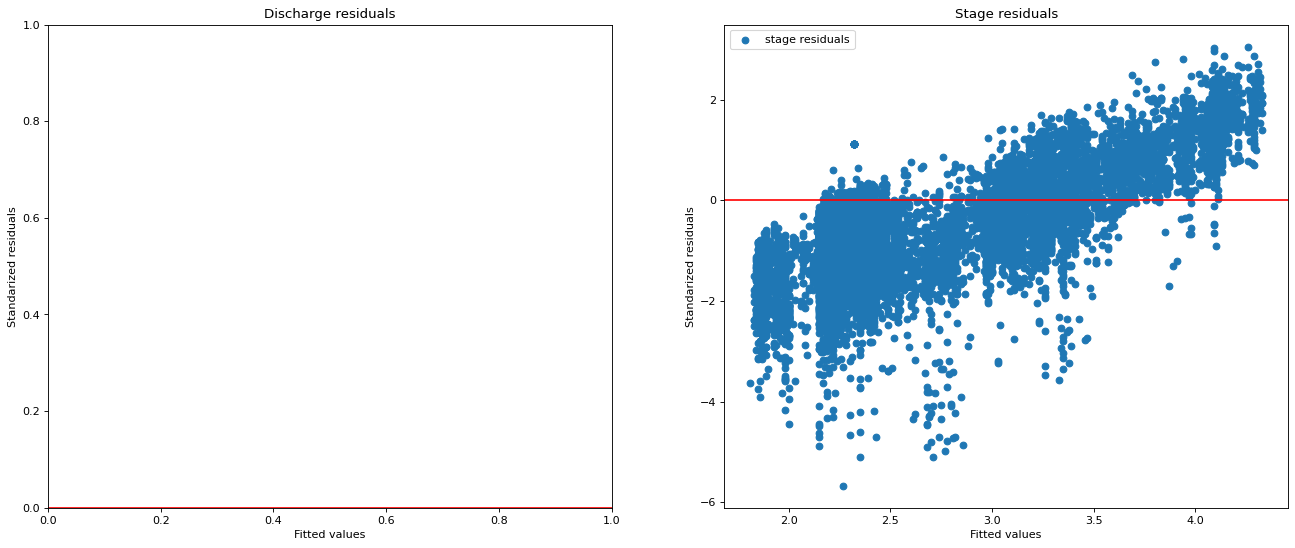

In [18]:
residuals = y_test - y_pred
residuals_std = residuals/residuals.std()

y_real_stage = y_test
residual_stage = residuals

#y_real_discharge = np.array([i[-1] for i in y_test])
#residual_discharge = np.array([i[-1] for i in residuals])


figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[1].scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
#ax[0].scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
ax[1].axhline(y=0.0, color='r', linestyle='-')
ax[0].axhline(y=0.0, color='r', linestyle='-')

ax[1].set_title("Stage residuals")
ax[0].set_title("Discharge residuals")

ax[1].set_xlabel("Fitted values")
ax[0].set_xlabel("Fitted values")
ax[1].set_ylabel("Standarized residuals")
ax[0].set_ylabel("Standarized residuals")

plt.legend()
plt.show()

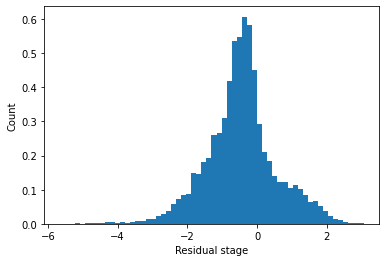

In [19]:
plt.hist(residual_stage / residual_stage.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual stage');
plt.show()

In [20]:
"""plt.hist(residual_discharge / residual_discharge.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual discharge');
plt.show()"""

"plt.hist(residual_discharge / residual_discharge.std(), density=True, bins = 60)\nplt.ylabel('Count')\nplt.xlabel('Residual discharge');\nplt.show()"

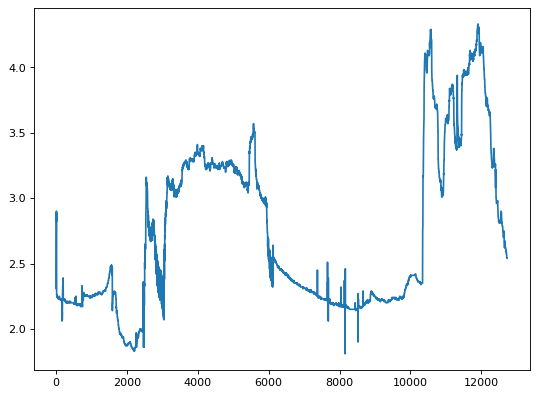

In [21]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(np.arange(len(y_test)), y_test, label="Stage real")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


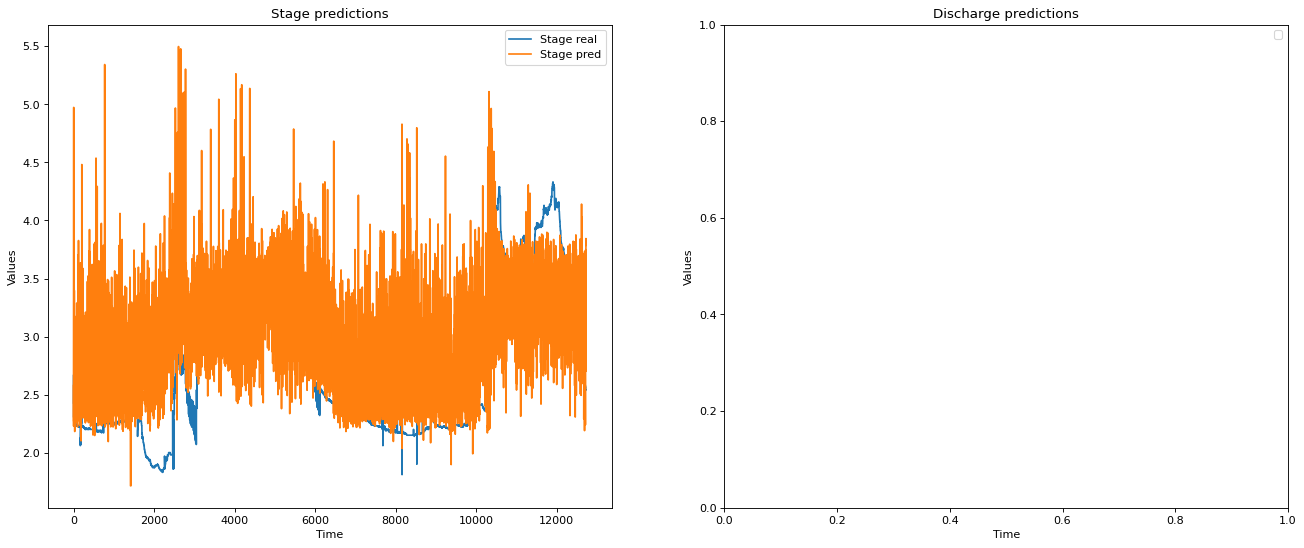

In [22]:
figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[0].plot(np.arange(len(y_test)), y_test, label="Stage real")
ax[0].plot(np.arange(len(y_test)), y_pred, label="Stage pred")

ax[0].set_title("Stage predictions")
ax[1].set_title("Discharge predictions")

ax[1].set_ylabel("Values")
ax[0].set_ylabel("Values")
ax[1].set_xlabel("Time")
ax[0].set_xlabel("Time")

ax[0].legend()
ax[1].legend()
plt.show()